## Compute PCA, do Logistic regression on the embedding, and kmeans on the predicted probability

## Outstanding questions
* what do we expect from the logistic regression predicted probabilities under a null (a homogeneous population randomly split in two)
* why is the logistic prediction spot on 0/1 accoording to batch, when we use all the data?
* why is kmeans so good? would lda/gaussian mixture do as well?
* would the normalization that yered suggested work well?
* benn suggested adding attention to the ae

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
# external dependencies
import os
import sys
notebook_path = os.path.abspath('.')
sources_path = os.path.abspath(os.path.join(notebook_path, '..'))
sys.path.insert(0, sources_path)
# import custom modules
import utils
import models
import dataloaders

# basic imports
import json
import pprint
import pickle
from tqdm.auto import tqdm, trange
from more_itertools import chunked

# scientific python
import matplotlib.pylab as plt
import numpy as np
import scipy as sp
import scipy.spatial.distance as spdist
import pandas as pd

RAND_SEED = 28
np.random.seed(RAND_SEED)

# ML/torch 
import ml_collections
import torch
from torch.utils.data import DataLoader, TensorDataset

# Scanpy modules
import scanpy as sc
import anndata

# Plotting
import seaborn as sns

device = torch.device("cuda")
#device = torch.device("cpu")
dtype = torch.float32

#torch.backends.cudnn.enabled = True
#torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark = False

utils.matplotlib_settings()
utils.print_module_versions([torch])

torch     : 1.6.0+cu101


# Load the preprocessed data

In [3]:
# save np.load
np_load_old = np.load
# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [356]:
# puck data prefix
PREFIX = 'citeseq_rna'#'sn'
PUCK_SUBNUMBER = 'naiveB_1900'#'mli2_30'
PUCK_NUMBER = f'{PUCK_SUBNUMBER}_memoryB_1404' #f'{PUCK_SUBNUMBER}genes_0.05_perturbed'

dirname = f'latent_space_structure/data/{PREFIX}_{PUCK_NUMBER}'

np_data = np.load(os.path.join(dirname, 'preprocessed_data.npz'))
print(list(np_data.keys()))
adata = sc.read(os.path.join(dirname, 'adata.h5ad'))

batch = pd.read_csv(f'latent_space_structure/data/{PUCK_NUMBER}/batch.csv')['x'].values
perturbed = pd.read_csv(f'latent_space_structure/data/{PUCK_NUMBER}/celltype.csv')['x'].values

negative_batch_mask = batch == 0
positive_batch_mask = batch == 1
negative_perturbed_mask = perturbed == "Naive B"
positive_perturbed_mask = perturbed == "Memory B"

adata.obs['batch'] = batch
adata.obs['perturbed'] = perturbed
log_normalized_expression_ng = adata.X

['puck_number', 'n_filtered_genes', 'bead_efficiency_hvgs_n', 'bead_efficiency_n', 'filtered_expression_gn', 'mean_umi_hvgs', 'filtered_gene_names', 'bead_barcodes_n']


## Scale Data for PCA

In [357]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_log_normalized_expression_ng = scaler.fit_transform(log_normalized_expression_ng)

## Utility functions

In [358]:
from sklearn.linear_model import LogisticRegression
import scipy as sp
from scipy.stats import describe as describe_stats


def standalone_logistic(X, y):
    clf = LogisticRegression(random_state=RAND_SEED, penalty='none').fit(X, y)
    predicted_label = clf.predict(X)
    predicted_prob = clf.predict_proba(X)
    return predicted_prob[:,1]

## PCA (already storred in the adata)

In [359]:
adata.obsm['X_pca']

array([[ -1.0860741 ,   6.573447  ,  -2.4913251 , ...,   2.000345  ,
         -5.230143  ,   1.9678042 ],
       [ -7.1192775 ,   1.0370191 ,   1.5305985 , ...,  -2.8227994 ,
          1.4548358 ,  -0.29499164],
       [-10.201066  ,   0.37640023,   6.841943  , ...,  -0.19636133,
          3.1099331 ,   3.3875332 ],
       ...,
       [  5.2899237 ,  -1.4492314 ,  -0.88962287, ...,  -1.7510065 ,
          0.8150813 ,   3.6776965 ],
       [  8.741908  ,  -5.5529795 ,  -1.0893836 , ...,   1.7796494 ,
         -2.491069  ,   1.196549  ],
       [  6.5721645 ,  -3.436066  ,  -3.557856  , ...,   4.6074524 ,
          2.2690282 ,  -2.2581263 ]], dtype=float32)

## UMAP of PCA

/opt/conda/envs/vizi/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'perturbed' as categorical


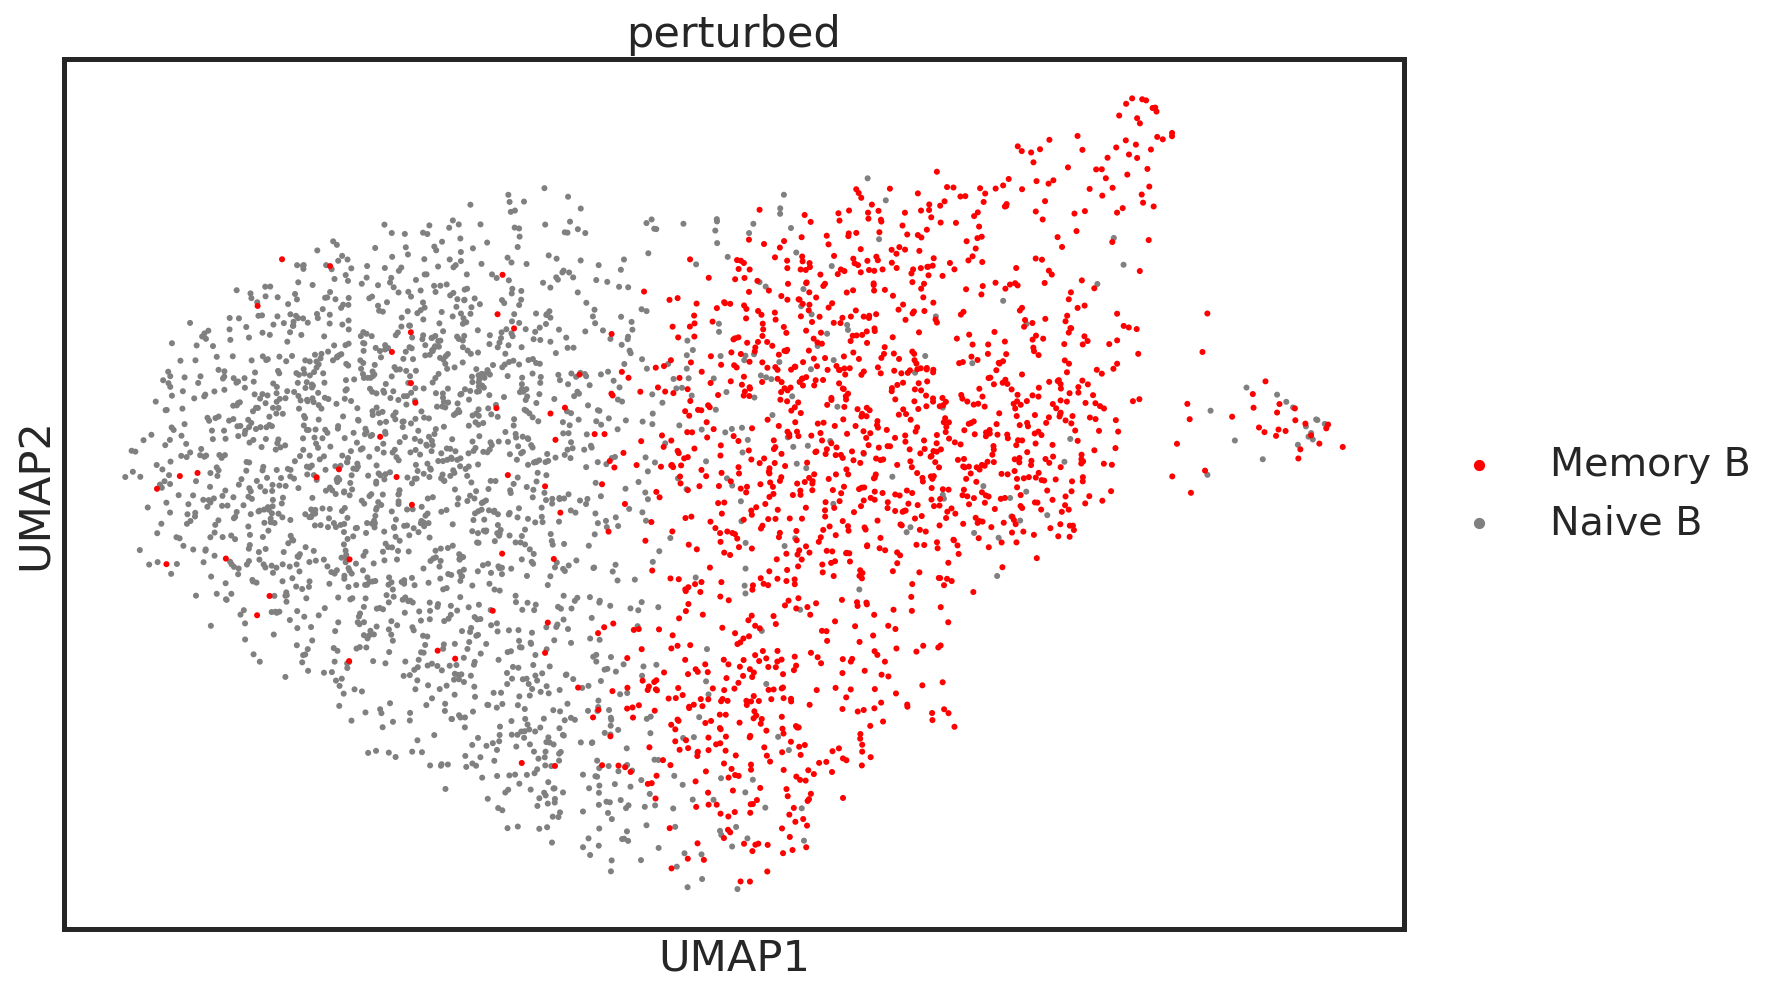

In [360]:
sc.pl.umap(adata, color='perturbed', palette=['red', 'gray'])

In [361]:
adata.obs['batch'] = batch
adata.obs['batch'] = adata.obs['batch'].astype('str')

... storing 'batch' as categorical


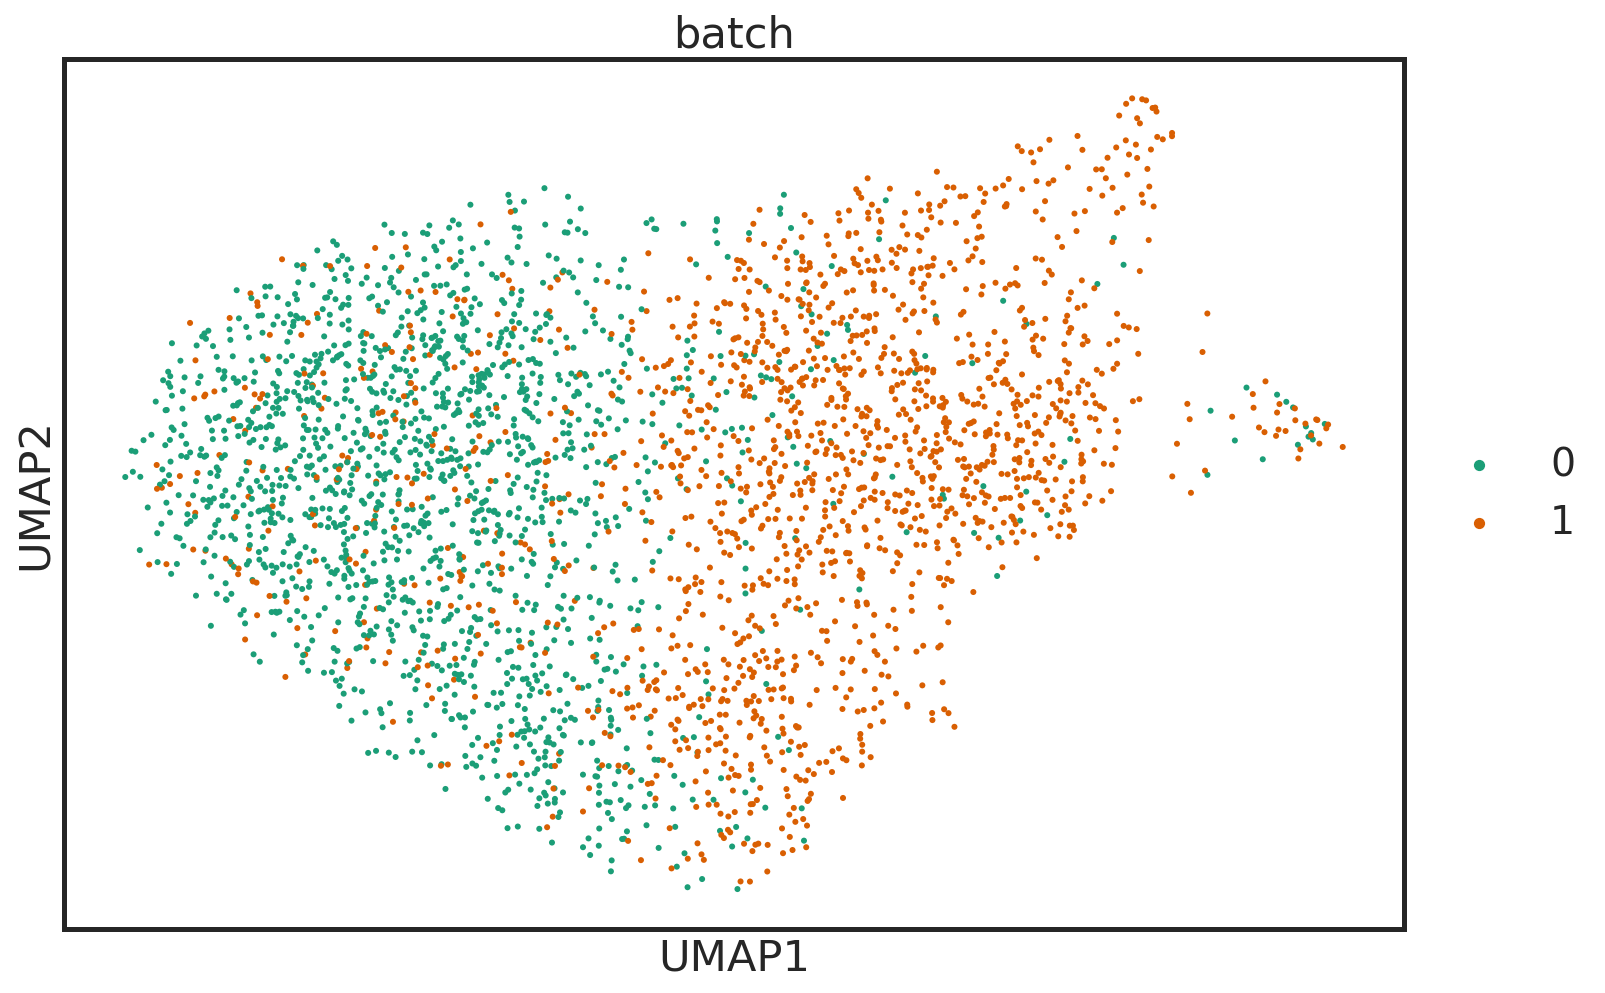

In [362]:
sc.pl.umap(adata, color='batch', palette=["#1B9E77", "#D95F02"])

In [363]:
#scaled_log_normalized_expression_ng

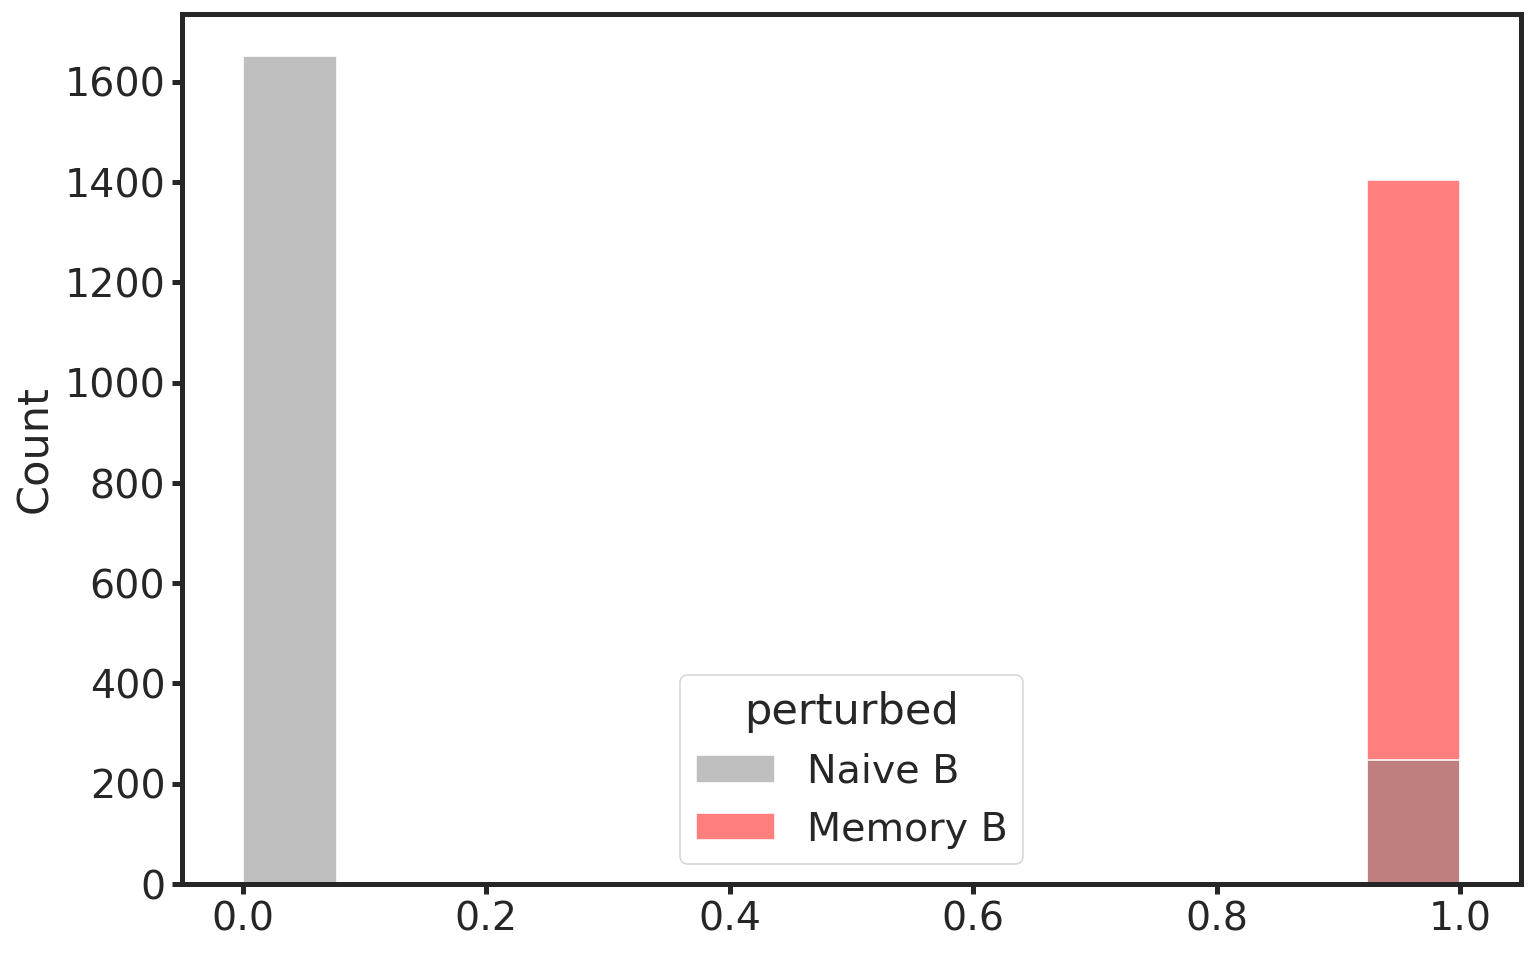

In [364]:
p_hat = standalone_logistic(scaled_log_normalized_expression_ng,#log_normalized_expression_ng,
                    batch.astype(np.float32))
df_p_hat = pd.DataFrame()
df_p_hat['p_hat'] = p_hat
df_p_hat['perturbed'] = perturbed

sns.histplot(x=p_hat,#np.exp(-tmp), 
             hue='perturbed', 
             palette={'Naive B':'gray','Memory B':'red'},
             data=df_p_hat)
plt.show()

In [365]:
#log_normalized_expression_ng

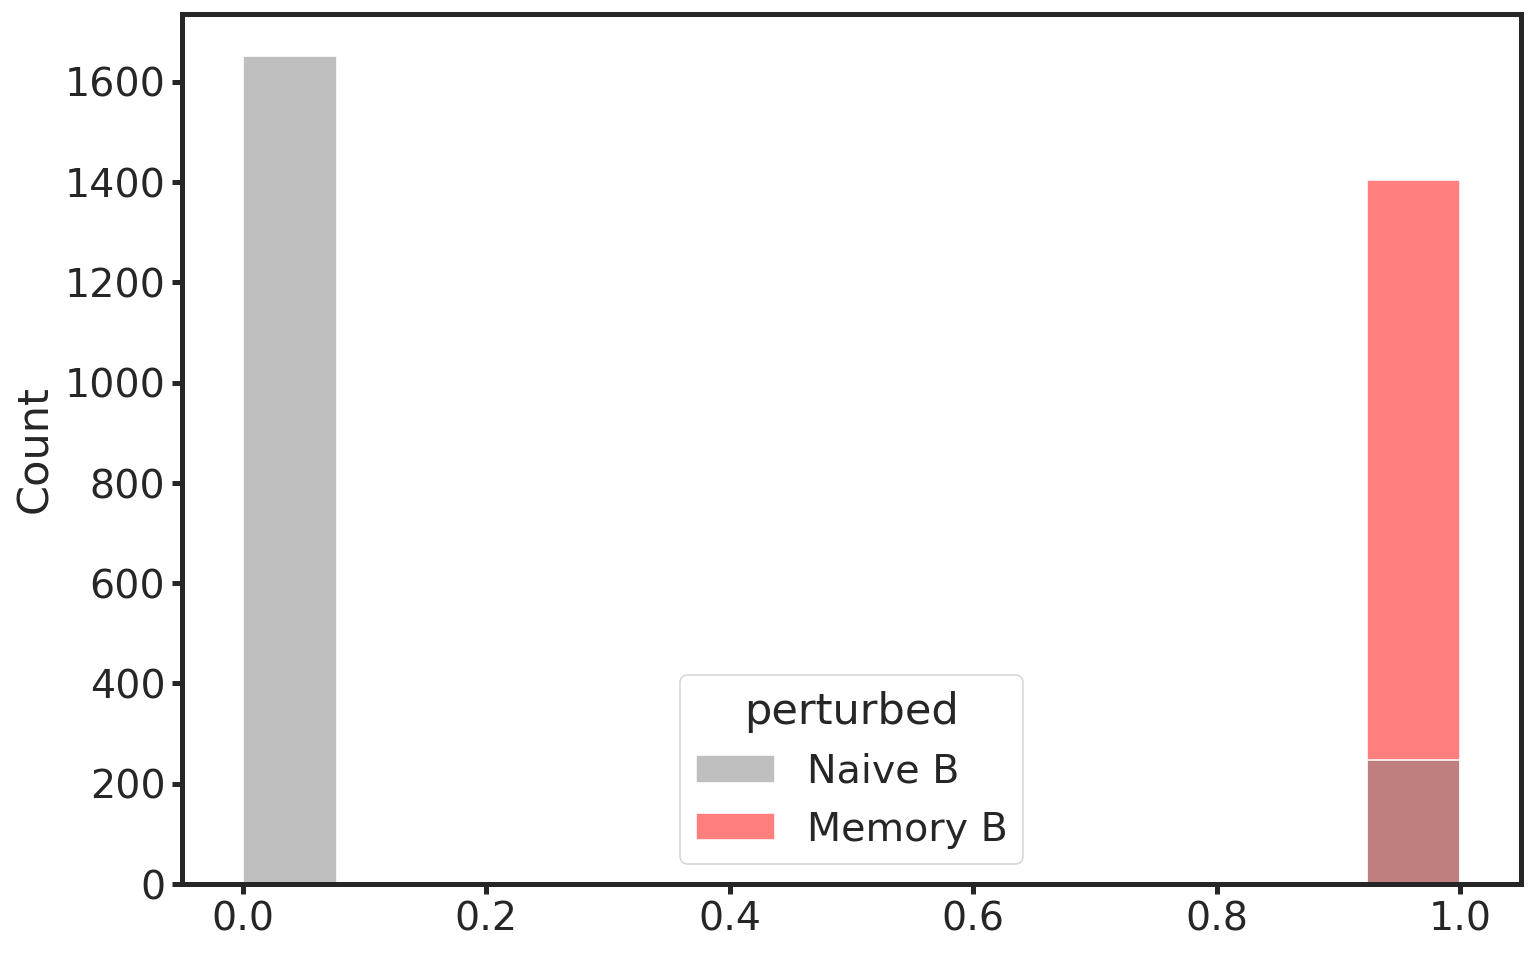

In [366]:
p_hat = standalone_logistic(log_normalized_expression_ng,
                    batch.astype(np.float32))
df_p_hat = pd.DataFrame()
df_p_hat['p_hat'] = p_hat
df_p_hat['perturbed'] = perturbed

sns.histplot(x=p_hat,#np.exp(-tmp), 
             hue='perturbed', 
             palette={'Naive B':'gray','Memory B':'red'},
             data=df_p_hat)
plt.show()

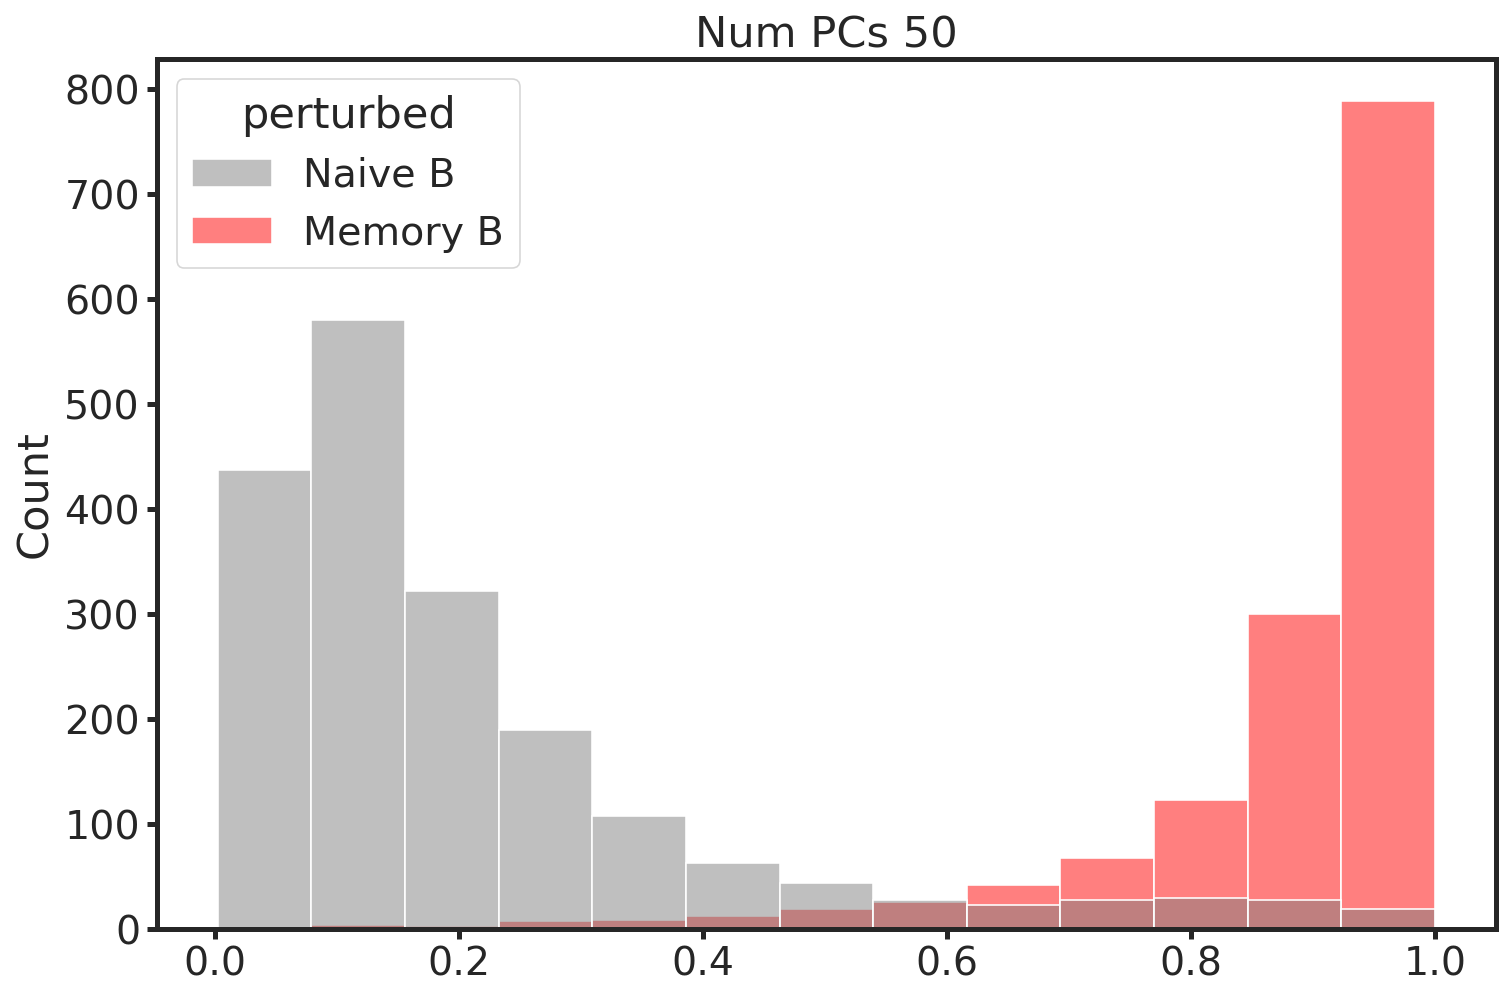

In [367]:
p_hat = standalone_logistic(adata.obsm['X_pca'],
                    batch.astype(np.float32))
df_p_hat = pd.DataFrame()
df_p_hat['p_hat'] = p_hat
df_p_hat['perturbed'] = perturbed
#df_tmp
sns.histplot(x=p_hat,
             hue='perturbed', 
             palette={'Naive B':'gray','Memory B':'red'},
             data=df_p_hat)
num_pcs = adata.obsm['X_pca'].shape[1]
plt.title(f'Num PCs {num_pcs}')
plt.show()

/opt/conda/envs/vizi/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


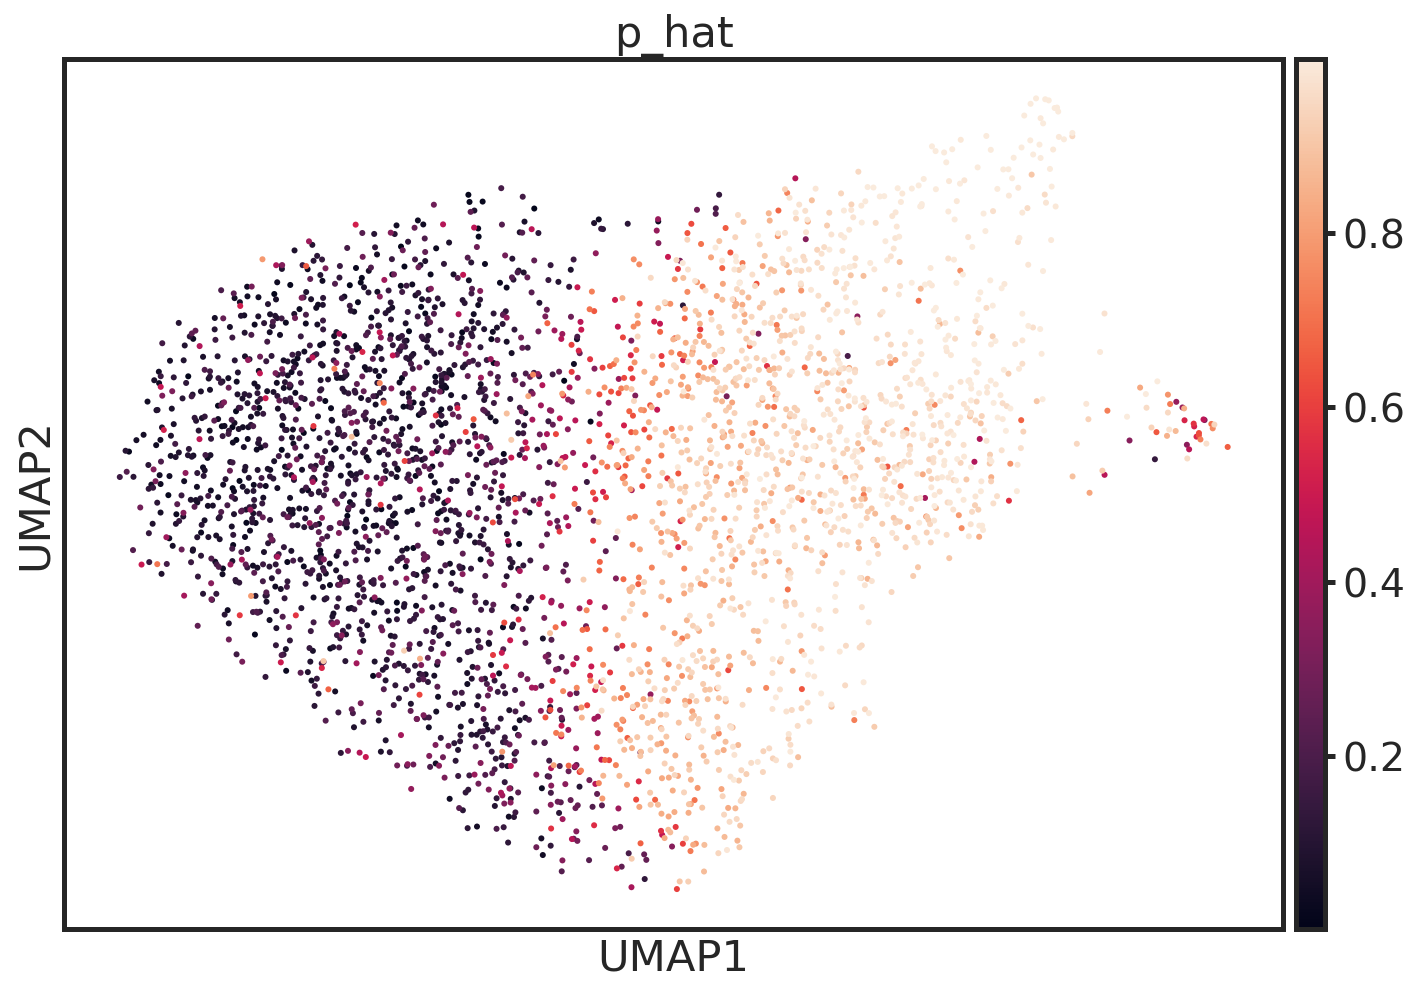

In [368]:
adata.obs['p_hat'] = p_hat
sc.pl.umap(adata, color='p_hat')

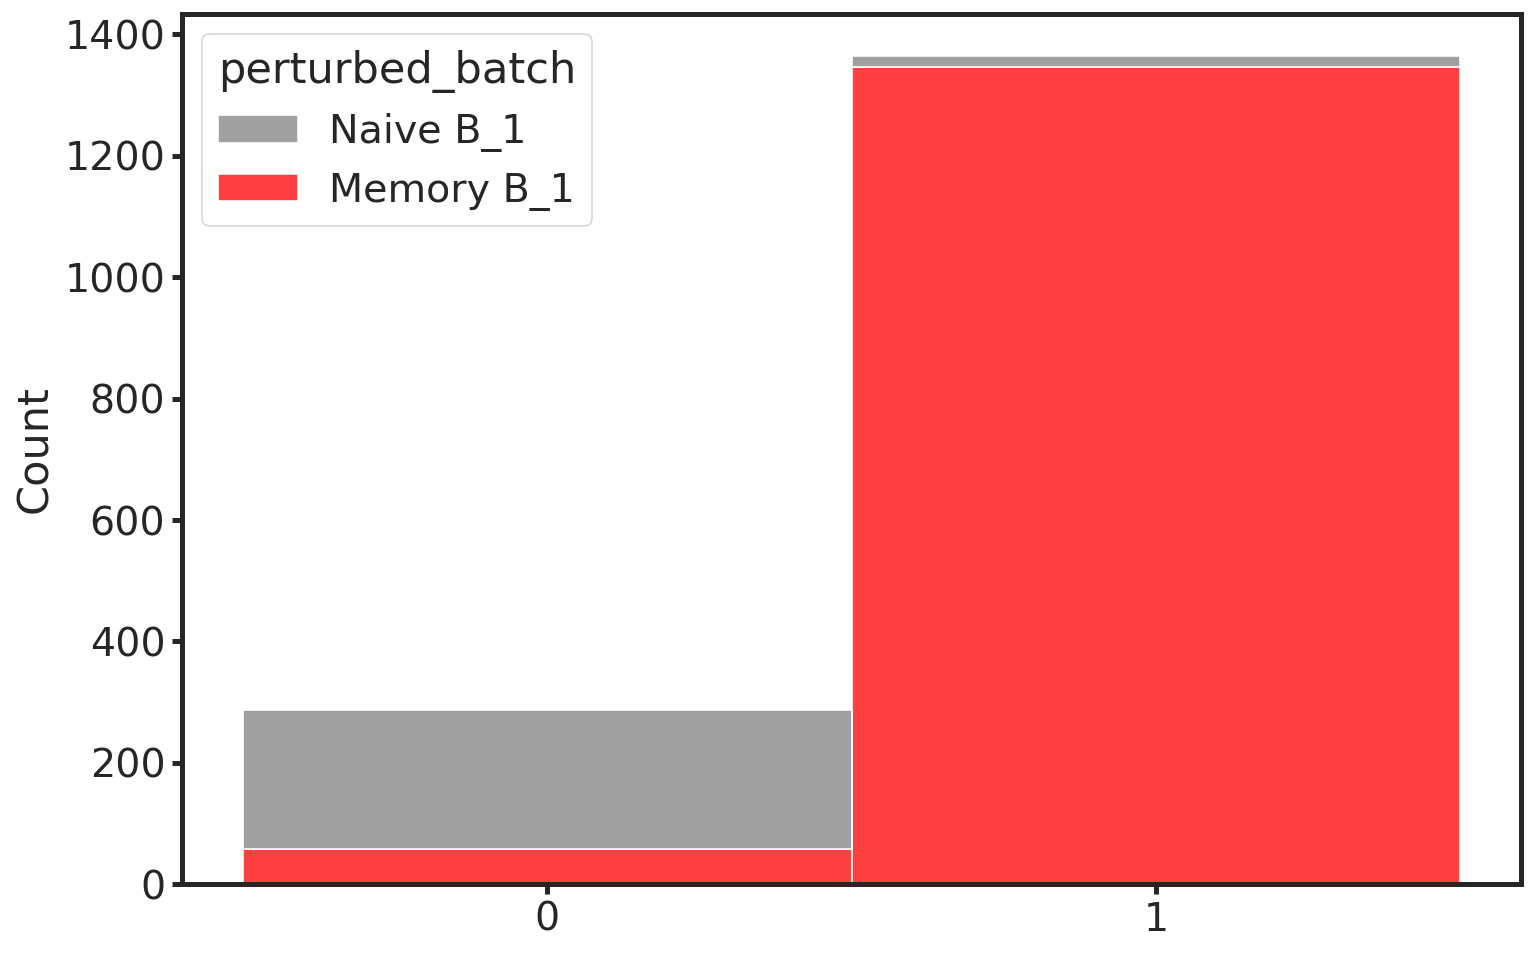

In [369]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(pd.DataFrame(p_hat)[batch==1])#(df.drop(['batch', 'perturbed'], axis=1))
kmeans.labels_
#kmeans.cluster_centers_

df = pd.DataFrame()
df['batch'] = adata.obs['batch'].values.astype(int)
df['perturbed'] = adata.obs['perturbed'].values
df_kmeans = df[batch==1].copy()
df_kmeans['perturbed_batch'] = df_kmeans.apply(lambda row: f'{row["perturbed"]}_{row["batch"]}', axis=1)
df_kmeans['kmeans_labels'] = kmeans.labels_
#df_kmeans.head()
sns.histplot(x=kmeans.labels_.astype('str'), 
             hue='perturbed_batch', 
             palette=['gray', 'red'],#sns.color_palette('Dark2', 2), 
             multiple='stack', 
             data=df_kmeans)
plt.show()

In [370]:
kmeans.cluster_centers_
# can try a gaussian mixture too
# maybe LDA also?

array([[0.22236748],
       [0.90741806]])

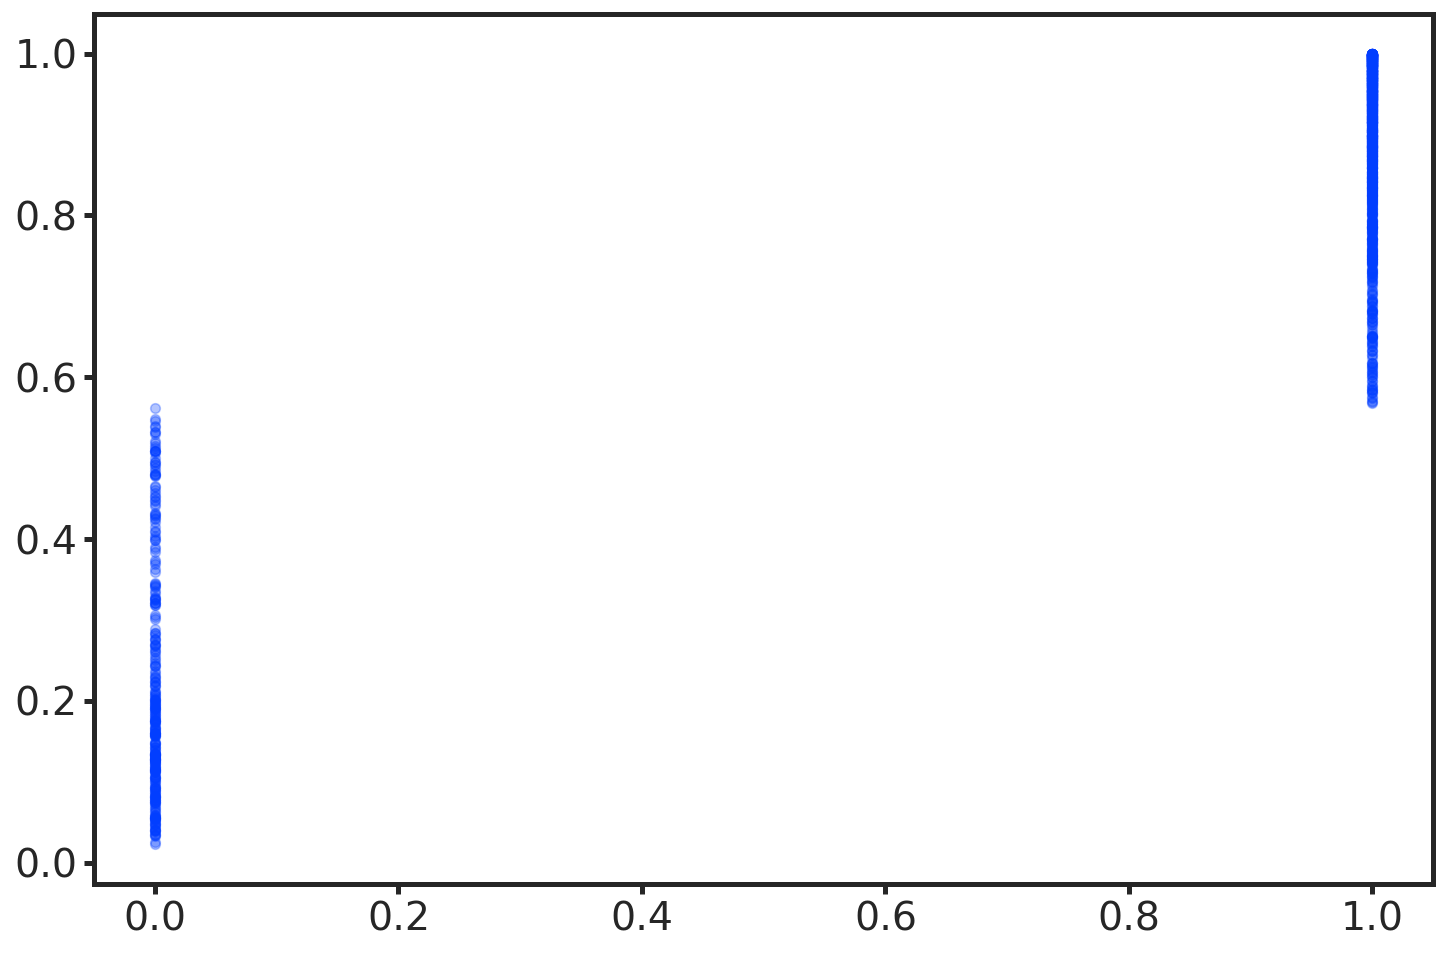

In [371]:
# this plot tell us which kmeans cluster is closer to 'batch 0'
plt.scatter(kmeans.labels_,
           pd.DataFrame(p_hat)[batch==1],
           alpha=0.3)

In [372]:
df_p_hat['kmeans'] = 0
df_p_hat['kmeans'][batch==1] = kmeans.labels_
df_p_hat['kmeans'].values

<ipython-input-372-9f05322a17ed>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_p_hat['kmeans'][batch==1] = kmeans.labels_


array([0, 0, 0, ..., 1, 1, 1])

In [333]:
# Only run if necessary
kmeans.labels_[kmeans.labels_==1]=2
kmeans.labels_[kmeans.labels_==0]=1
kmeans.labels_[kmeans.labels_==2]=0
df_p_hat['kmeans'] = 0
df_p_hat['kmeans'][batch==1] = kmeans.labels_
df_p_hat['kmeans'].values

<ipython-input-333-e58f3978cc29>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_p_hat['kmeans'][batch==1] = kmeans.labels_


array([0, 0, 0, ..., 1, 1, 1])

# Save kmeans on logistic on pca results

In [373]:
np.save(f'latent_space_structure/data/{PUCK_NUMBER}/kmeans_logistic_pca.npy', df_p_hat['kmeans'].values)

In [374]:
labs = np.load(f'latent_space_structure/data/{PUCK_NUMBER}/kmeans_logistic_pca.npy')
labs

array([0, 0, 0, ..., 1, 1, 1])

<ipython-input-178-be6db1941019>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_p_hat['kmeans'][batch==1] = kmeans.labels_


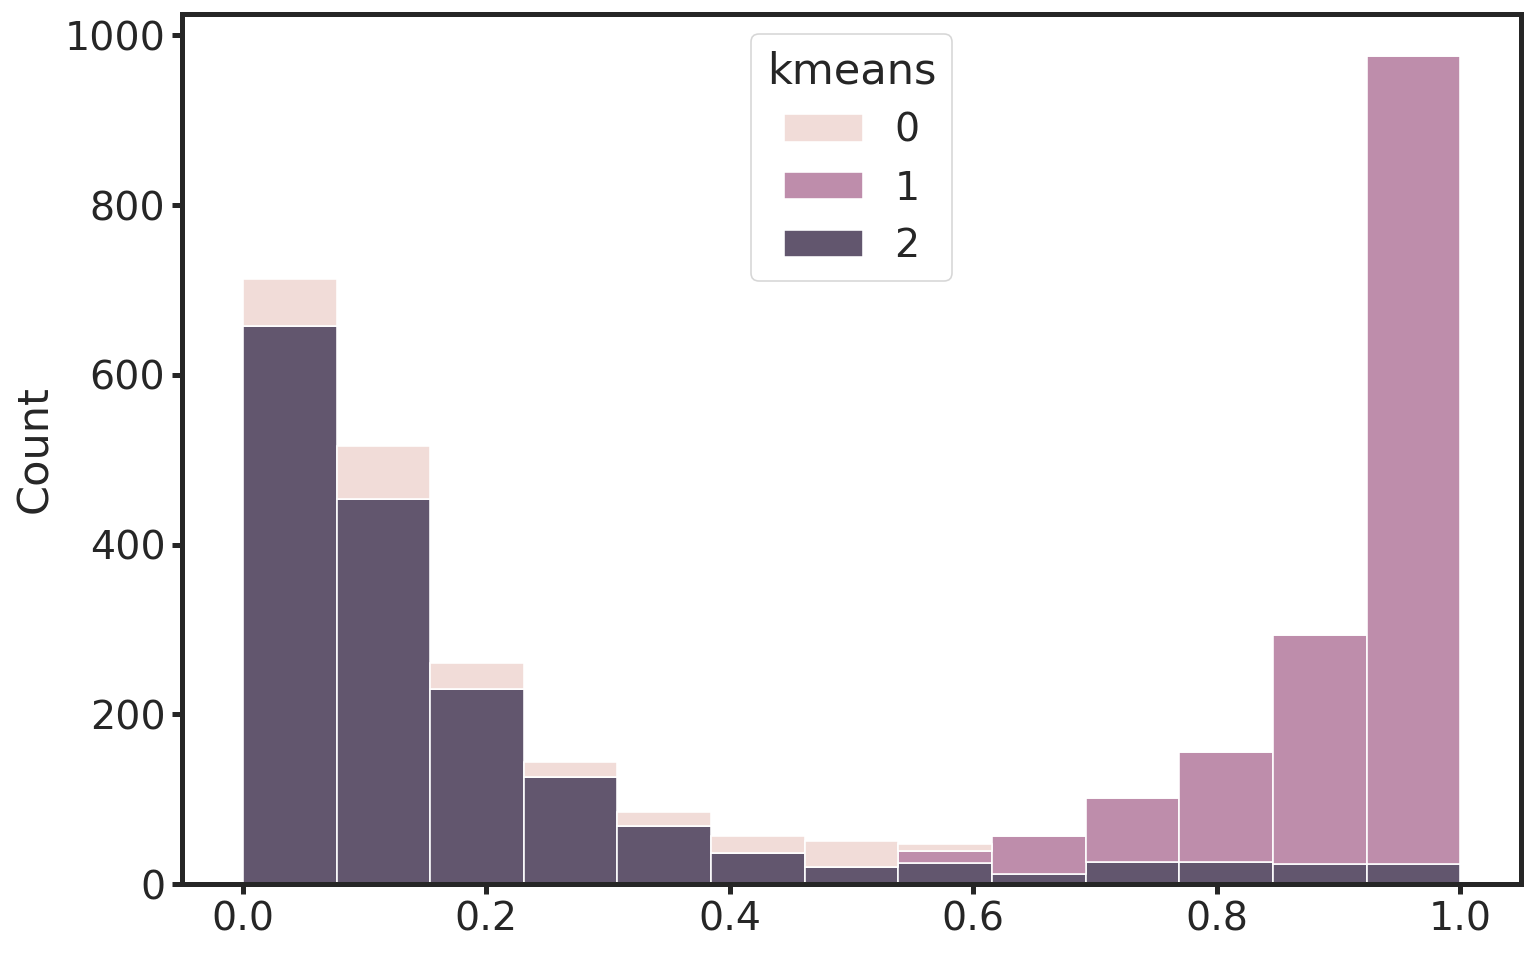

In [178]:
df_p_hat['kmeans'] = 2
df_p_hat['kmeans'][batch==1] = kmeans.labels_
sns.histplot(x=p_hat,
             hue='kmeans', 
             #palette={'Naive B':'gray','Memory B':'red'},
             data=df_p_hat,
             multiple='stack')
num_pcs = adata.obsm['X_pca'].shape[1]
#plt.title(f'Num PCs {num_pcs}')
plt.show()

/opt/conda/envs/vizi/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'kmeans_labels' as categorical
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequenc

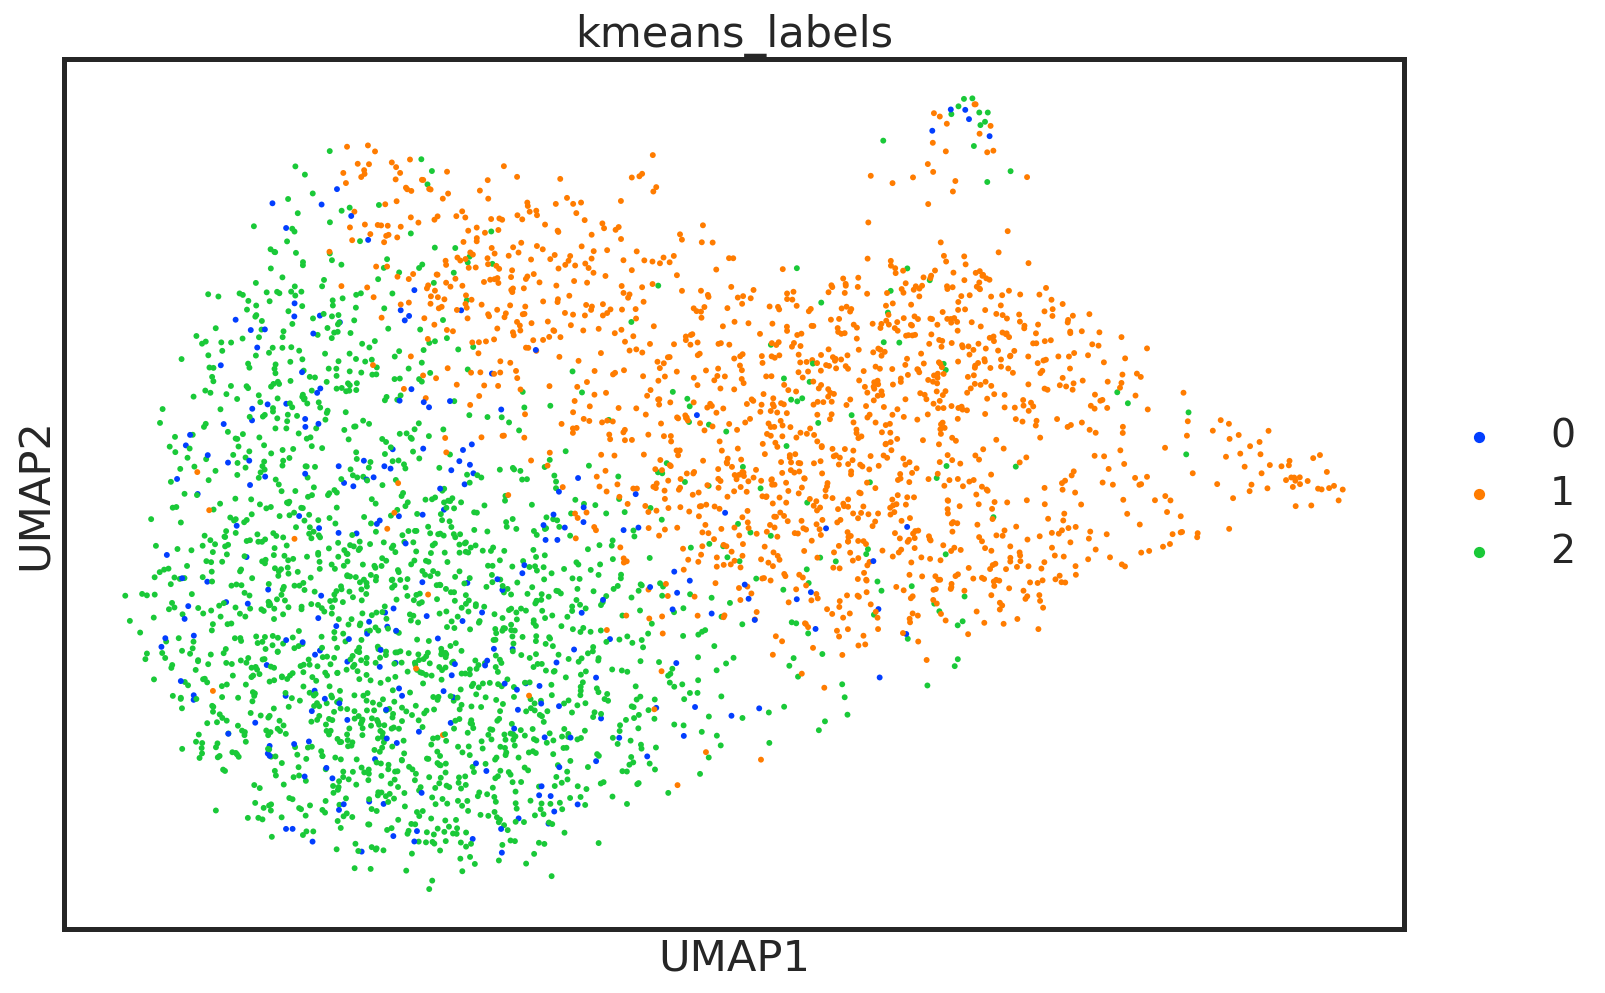

In [179]:
adata.obs['kmeans_labels'] = df_p_hat['kmeans'].values.astype('str')
sc.pl.umap(adata, color='kmeans_labels')

In [180]:
plt.scatter(tmp[batch==1], tmp[batch==1], c=kmeans.labels_==1, alpha=0.5)
# i want a two by two table, with perturbed/nnot perturbed, and kmeans label 0 and 1

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2054 but corresponding boolean dimension is 3455

In [181]:
plt.scatter(tmp[batch==1], tmp[batch==1], c=perturbed[batch==1]=='Memory B', alpha=0.5)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2054 but corresponding boolean dimension is 3455